In [ ]:
# Проверка на тестовом датасете

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix

import project_module

In [494]:
reload(project_module)

<module 'project_module' from 'project_module.py'>

Загрузка данных теста

In [408]:
# Определим ОС, подготовимся к загрузке
OSTYPE = !uname
if OSTYPE == ['Linux']:
     OSTYPE = 'Linux'
else:
     OSTYPE = 'Windows'
        
source_list = None
current_dir = None
if OSTYPE == 'Linux':
    source_list = !find ./for_test/ -type f | sort
else:
    source_list = !dir "for_test/30s" /B /S
    current_dir = !echo %cd%
    current_dir = current_dir[0]

file_list = project_module.GetFilenameList(source_list, OSTYPE, current_dir)

In [409]:
# Загрузим данные
audio_data = project_module.LoadAudio(file_list, True, OSTYPE)

In [410]:
# И еще нужно загрузить метки
labels_df = pd.read_csv("models/labels.csv", index_col=0)
labels = labels_df.iloc[:, 0].to_dict()
labels_list = labels_df.index.values

In [425]:
labels_df

,id
blues,0
classical,1
country,2
disco,3
hiphop,4
jazz,5
metal,6
pop,7
reggae,8
rock,9


In [ ]:
x_means = pd.read_csv("means.csv").iloc[:, 1].values
x_stds = pd.read_csv("stds.csv").iloc[:, 1].values

In [488]:
# Подготовим датасет
X_test, y_test = project_module.PrepareDataForModel(audio_data, labels, x_means, x_stds)
X_test_nn, y_test_nn = project_module.PrepareDataForModel(audio_data, labels, x_means, x_stds, normalize=False)

Загрузка моделей

In [412]:
# Загрузим модели
model_pcasvc = joblib.load('models/pcasvc.pkl') 
model_lda = joblib.load('models/lda.pkl')
model_pcasvc_nn = joblib.load('models/pcasvc_nn.pkl') 
model_lda_nn = joblib.load('models/lda_nn.pkl')

** Момент истины - тест! **

* Нормализованные модели

In [413]:
plt.rcParams["axes.grid"] = False

In [414]:
model_lda

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)

In [506]:
def PredictAndShow(model, X, y, name):
    y_pred = model.predict(X)
    print "Accuracy", accuracy_score(y_true=y, y_pred=y_pred)

    cnf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)
    plt.figure()
    project_module.PlotConfusionMatrix(cnf_matrix, classes=labels_list, normalize=True,  title=name)
    plt.show()
    
    return y_pred

Accuracy 0.418367346939
Confusion matrix, without normalization
[[2 0 2 1 1 0 0 1 0 3]
 [0 8 2 0 0 0 0 0 0 0]
 [0 0 3 1 1 0 0 3 0 2]
 [0 0 0 5 1 0 0 2 1 1]
 [0 0 3 2 1 0 0 2 2 0]
 [0 0 2 1 0 3 0 0 1 2]
 [1 0 0 1 0 0 6 0 0 2]
 [0 0 1 1 1 0 0 6 1 0]
 [0 0 0 1 0 0 0 4 5 0]
 [0 0 2 1 0 1 1 1 1 2]]


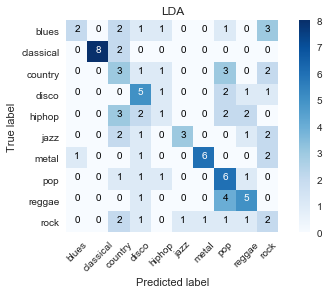

[3 7 4 9 0 3 6 9 7 8 4 7 8 9 6 2 2 4 1 1 7 8 9 3 9 3 3 4 7 3 3 3 8 6 9 2 1
 5 8 1 2 1 7 7 8 9 7 7 9 2 5 4 8 1 2 8 9 6 5 9 5 8 0 1 9 8 2 2 3 1 7 3 2 7
 3 2 7 6 6 7 2 3 7 2 7 7 9 3 3 0 7 7 6 7 2 2 2 8]
[3 7 2 2 6 8 6 6 4 8 4 7 8 9 6 2 1 3 1 1 3 8 9 5 2 3 0 7 7 3 7 2 5 9 5 9 1
 5 9 1 0 1 2 8 8 0 7 7 6 0 9 0 3 1 2 8 0 6 5 3 5 7 0 1 5 4 2 4 6 1 8 4 4 9
 3 7 2 6 6 8 9 4 8 4 2 3 0 9 3 0 4 0 6 7 5 5 1 4]


In [489]:
print PredictAndShow(model_lda, X_test, y_test, "LDA")
print y_test

Вероятностная классификация

In [490]:
#Минус - поменять порядок
y_proba = model_lda.predict_proba(X_test)
arg_sort = np.argsort(-y_proba)

count_first3 = 0
for i, sample in enumerate(arg_sort):
    position = np.where(sample == y_test[i])[0][0]
    if (position < 3):
        count_first3 += 1
        
# % треков, где нужный жанр находится среди первых 3х предложенных
print float(count_first3)/X_test.shape[0]

0.734693877551


In [491]:
# Вывод 3х предложенных жанров для 1ой песни
print "Скорее всего, это ", labels_df.iloc[arg_sort[0, 0]].name
print "но это еще может быть", labels_df.iloc[arg_sort[0, 1]].name, "или", labels_df.iloc[arg_sort[0, 2]].name
print "А на самом деле это", labels_df.iloc[y_test[0]].name

Скорее всего, это  disco
но это еще может быть rock или metal
А на самом деле это disco


Accuracy 0.448979591837
Confusion matrix, without normalization
[[1 0 5 2 1 0 0 0 1 0]
 [0 9 1 0 0 0 0 0 0 0]
 [0 0 6 1 0 0 0 1 2 0]
 [0 0 2 5 1 0 0 0 1 1]
 [0 0 1 0 2 0 0 3 4 0]
 [0 0 1 1 0 4 0 0 1 2]
 [0 0 0 0 2 0 6 0 0 2]
 [0 0 3 2 0 0 0 4 1 0]
 [0 0 2 1 1 0 0 0 6 0]
 [0 1 3 1 0 0 2 0 1 1]]


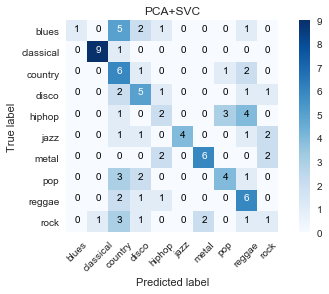

array([3, 7, 8, 2, 4, 3, 6, 9, 7, 8, 4, 7, 8, 9, 6, 2, 2, 4, 1, 1, 3, 8, 6,
       3, 8, 2, 3, 3, 8, 3, 3, 3, 8, 6, 9, 2, 1, 5, 8, 1, 2, 1, 7, 8, 8, 3,
       7, 7, 4, 2, 1, 4, 8, 1, 2, 4, 2, 6, 2, 9, 5, 2, 0, 1, 9, 8, 2, 2, 9,
       1, 2, 8, 8, 2, 3, 2, 2, 6, 6, 8, 2, 7, 2, 8, 2, 3, 8, 3, 2, 2, 7, 2,
       6, 2, 5, 5, 1, 4], dtype=int64)

In [492]:
PredictAndShow(model_pcasvc, X_test, y_test, "PCA+SVC")

##### Мы возьмем LDA, поскольку в нем есть вероятностная классификация, что позволит несколько сгладить недостатки классификатора

* Ненормализованные модели (на всякий случай)

Accuracy 0.15306122449
Confusion matrix, without normalization
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  2  0  0  7  0  0  1  0  0]
 [ 0  0  0  0  7  0  0  3  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  2  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  5  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]]


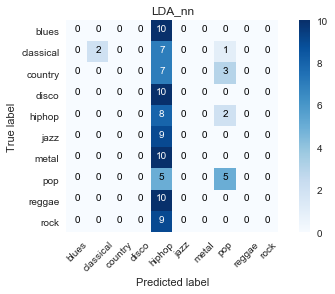

In [361]:
PredictAndShow(model_lda_nn, X_test_nn, y_test_nn, "LDA_nn")

Accuracy 0.112244897959
Confusion matrix, without normalization
[[ 1  0  0  0  9  0  0  0  0  0]
 [ 3  0  0  1  6  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 1  0  0  0  8  0  0  0  0  0]]


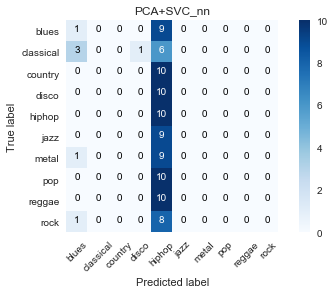

In [362]:
PredictAndShow(model_pcasvc_nn, X_test_nn, y_test_nn, "PCA+SVC_nn")

** Классификация полных песен **

In [474]:
reload(project_module)

<module 'project_module' from 'project_module.pyc'>

In [475]:
source_list_full = None

if OSTYPE == 'Linux':
    source_list_full = !find ./for_test/ -type f | sort
else:
    source_list_full = !dir "for_test/full" /B /S
    current_dir_full = !echo %cd%

file_list_full = project_module.GetFilenameList(source_list_full, OSTYPE, current_dir)

In [476]:
np.random.seed(7)

In [496]:
full_song_df = project_module.LoadAudio(file_list_full, False, OSTYPE, crop=True)

In [497]:
X_full, y_full = project_module.PrepareDataForModel(full_song_df, labels, x_means, x_stds, shuffle=False)

In [498]:
y_full_proba = model_lda.predict_proba(X_full)
y_pred = model_lda.predict(X_full)
y_full_texts = list()
for i, probabilities in enumerate(y_full_proba):
    arg_sort = np.argsort(-probabilities)
    y_full_texts.append(labels_df.iloc[arg_sort[0]].name+" > "+labels_df.iloc[arg_sort[1]].name+" > "+
                        labels_df.iloc[arg_sort[2]].name)
    #print labels_df.iloc[y_pred[i]].name
    print y_full_texts[i], ", filename:", full_song_df.file_name[i]
full_song_df.genre = y_full_texts

rock > country > disco , filename: blues_HouseOfTheRisingSunTim Griffin.wav
classical > jazz > country , filename: classic_TanetsMalenkihLebedey.wav
pop > country > blues , filename: country_BetterManLittleBigTown.wav
disco > reggae > hiphop , filename: disco_BodyTalkImagination.wav
hiphop > reggae > disco , filename: hiphop_AllEyezOnMe2Pac.wav
country > reggae > disco , filename: jazz_RudolphTheRedNosedReindeerEllaFitzgerald.wav
metal > disco > hiphop , filename: metal_AtlasRiseMetallica.wav
disco > hiphop > rock , filename: pop_IDidSomethingBadTaylorSwift.wav
hiphop > reggae > disco , filename: raggae_DanceElephantMan.wav
rock > disco > reggae , filename: rock_AreYouDreamingDiaryofMyMisanthropy.wav


In [499]:
full_song_df

,genre,file_name,samplerate,duration,mean,std,max,min,diff_mean,diff_std
0,rock > country > disco,blues_HouseOfTheRisingSunTim Griffin.wav,22050,297,"[-0.775974171359, -9.84999732584, 2.3376178691...","[1.42660048866, 9.79569854043, 7.56859002321, ...","[3.53297216689, 14.0348023127, 27.5367162547, ...","[-3.99973965308, -41.8584880324, -25.482892166...","[-9.07402315448, 12.1876151949, 1.67842922632,...","[11.0310566609, 15.1956369064, 10.5221119268, ..."
1,classical > jazz > country,classic_TanetsMalenkihLebedey.wav,22050,94,"[-6.79256189016, 4.98718146093, -21.9960095473...","[1.26361553207, 5.19312440276, 7.78662957604, ...","[-3.6935813685, 17.8401049646, 0.875938762424,...","[-9.72860176688, -13.8038055535, -42.448545313...","[11.7797433511, -26.9831910083, 23.648735443, ...","[5.523304859, 7.93028070669, 8.83717370863, 8...."
2,pop > country > blues,country_BetterManLittleBigTown.wav,22050,259,"[-1.79066015491, 11.5743396245, -3.14617859205...","[1.25184033958, 9.07543698209, 9.5962018932, 9...","[1.97134656551, 35.2435723437, 27.34956062, 39...","[-5.7753570552, -32.213248411, -39.8537934423,...","[13.3649997795, -14.7205182166, 6.15500780314,...","[9.71166087536, 12.6660818611, 13.8177065129, ..."
3,disco > reggae > hiphop,disco_BodyTalkImagination.wav,22050,368,"[-3.08095000661, -9.66589654515, -6.3403824234...","[1.82748708488, 8.54497186917, 11.0187235513, ...","[0.927470597283, 18.3089695442, 33.333973532, ...","[-10.5544942927, -39.9915700783, -44.639944161...","[-6.58494653853, 3.32551412168, 6.14502803498,...","[9.58050320798, 16.3608231653, 16.503774567, 1..."
4,hiphop > reggae > disco,hiphop_AllEyezOnMe2Pac.wav,22050,246,"[0.0494138698102, -12.5159045663, -3.837862128...","[1.60569417022, 11.4609427629, 12.0721221578, ...","[3.22809729588, 19.0315143506, 37.5881872156, ...","[-10.0119307187, -54.9163777413, -41.214845965...","[-12.5653184362, 8.67804243809, 10.5645239971,...","[12.0233583314, 18.7199272792, 16.4918136184, ..."
5,country > reggae > disco,jazz_RudolphTheRedNosedReindeerEllaFitzgerald.wav,22050,93,"[-0.576150788156, -7.25155602224, -7.189678483...","[1.15238547123, 9.42317699375, 10.2117959392, ...","[2.87747679255, 10.7248225409, 29.7966835078, ...","[-5.02686435234, -48.8251579914, -35.321960799...","[-6.67540523408, 0.0618775385991, 3.7087869645...","[10.2426916458, 16.1075593801, 13.9065182451, ..."
6,metal > disco > hiphop,metal_AtlasRiseMetallica.wav,22050,388,"[1.4676730862, -19.7760110875, -7.7981308614, ...","[0.820434971789, 5.39914556356, 7.41917180901,...","[3.13139989171, 6.9308084966, 19.0627824206, 3...","[-3.15533752586, -33.8903438949, -50.401150273...","[-21.2436841736, 11.977880226, 13.7327052312, ...","[6.05886555188, 10.5626028564, 9.53017373182, ..."
7,disco > hiphop > rock,pop_IDidSomethingBadTaylorSwift.wav,22050,215,"[-0.300496643002, -8.63179672854, 0.0787759330...","[1.49672934893, 8.69143578864, 10.0093723318, ...","[4.13506839616, 25.3988992148, 34.7756504926, ...","[-6.04837669513, -53.2663354893, -47.319936946...","[-8.33130008554, 8.71057266161, -9.08768608893...","[9.79006644117, 14.1666385296, 12.9470940368, ..."
8,hiphop > reggae > disco,raggae_DanceElephantMan.wav,22050,211,"[0.381908295636, -17.9810947639, -9.7196480368...","[1.02313991119, 7.38699127905, 9.2550261092, 1...","[2.95319935828, 1.3902141884, 25.2504265547, 3...","[-3.04503504939, -45.3526682227, -45.327472199...","[-18.3630030595, 8.26144672703, 8.38956319377,...","[7.87208875742, 10.8744410472, 12.3811182047, ..."
9,rock > disco > reggae,rock_AreYouDreamingDiaryofMyMisanthropy.wav,22050,175,"[0.307121811045, -7.12124361653, -24.657819870...","[1.26512845178, 8.12394946206, 9.58967294921, ...","[2.82148835301, 16.5579328789, 25.181060562, 2...","[-4.13881949982, -40.9141142044, -56.693936964...","[-7.42836542757, -17.5365762541, 27.5220710166...","[8.58425603453, 15.7674164274, 14.2716355628, ..."


Тест датасета полных песен

In [481]:
source_list_all_full = None
if OSTYPE == 'Linux':
    source_list_all_full = !find ./for_test/full_all -type f | sort
else:
    source_list_all_full = !dir "for_test/full_all" /B /S

file_list = project_module.GetFilenameList(source_list_all_full, OSTYPE, current_dir)

In [503]:
np.random.seed(13)
audio_data_full_all = project_module.LoadAudio(file_list, True, OSTYPE, crop=True)

Accuracy 0.443298969072
Normalized confusion matrix
[[ 0.5         0.          0.1         0.          0.1         0.          0.
   0.          0.          0.3       ]
 [ 0.          0.88888889  0.11111111  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.1         0.          0.3         0.1         0.1         0.          0.
   0.2         0.          0.2       ]
 [ 0.          0.          0.          0.5         0.1         0.          0.
   0.2         0.1         0.1       ]
 [ 0.          0.          0.          0.3         0.3         0.          0.
   0.2         0.2         0.        ]
 [ 0.          0.11111111  0.          0.44444444  0.11111111  0.22222222
   0.          0.          0.          0.11111111]
 [ 0.          0.          0.          0.2         0.1         0.          0.5
   0.          0.          0.2       ]
 [ 0.          0.          0.          0.2         0.          0.          0.
   0.7         0.          0.1       ]
 [ 

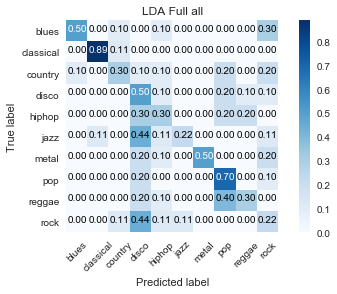

array([4, 0, 2, 0, 0, 9, 0, 9, 0, 9, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 7,
       4, 9, 7, 9, 3, 0, 7, 4, 9, 3, 7, 3, 8, 3, 3, 3, 4, 3, 4, 4, 3, 3, 7,
       8, 7, 8, 3, 9, 3, 3, 1, 5, 5, 3, 4, 6, 6, 9, 3, 3, 6, 6, 6, 4, 9, 7,
       7, 7, 3, 3, 9, 7, 7, 7, 7, 8, 3, 8, 7, 7, 7, 4, 3, 7, 8, 4, 3, 2, 9,
       5, 9, 3, 3, 3], dtype=int64)

In [507]:
X_test_full_all, y_test_full_all = project_module.PrepareDataForModel(audio_data_full_all, labels, x_means, x_stds, shuffle=False)
PredictAndShow(model_lda, X_test_full_all, y_test_full_all, "LDA Full all")

In [505]:
#Минус - поменять порядок
y_proba_full_all = model_lda.predict_proba(X_test_full_all)
arg_sort_full_all = np.argsort(-y_proba_full_all)

count_first3 = 0
for i, sample in enumerate(arg_sort_full_all):
    position = np.where(sample == y_test_full_all[i])[0][0]
    if (position < 3):
        count_first3 += 1
        
# % треков, где нужный жанр находится среди первых 3х предложенных
print float(count_first3)/X_test_full_all.shape[0]

0.670103092784
